In [13]:
import time
import numpy as np

import os.path as op

from copy import deepcopy

from tqdm import tqdm
import matplotlib.pyplot as plt

import h5py

import nibabel as nib

import sys
sys.path.append("../")

from src import power_crtl
from src import pkl_custom
from src import plot_stat_on_surf

import networkx as nx


In [14]:
def flatten_distribution(arr):
    """
    Flattens the distribution of a numpy array while keeping the original order.
    
    Parameters:
    arr (numpy.ndarray): Input array to be flattened.
    
    Returns:
    numpy.ndarray: Flattened array with the same order as the input.
    """
    sorted_indices = np.argsort(arr)
    sorted_arr = np.sort(arr)
    flattened_arr = np.linspace(sorted_arr[0], sorted_arr[-1], len(arr))
    result = np.empty_like(arr)
    result[sorted_indices] = flattened_arr
    return result

def gaussianize_distribution(arr):
    """
    Projects a distribution of a numpy array into a Gaussian distributed array while keeping the original order.
    
    Parameters:
    arr (numpy.ndarray): Input array to be transformed.
    
    Returns:
    numpy.ndarray: Gaussianized array with the same order as the input.
    """
    sorted_indices = np.argsort(arr)
    gaussian_arr = np.random.normal(loc=0, scale=1, size=len(arr))
    gaussian_arr.sort()
    result = np.empty_like(arr)
    result[sorted_indices] = gaussian_arr
    return result

def even_distribution(distrib, factor=2):
    if factor == -1:
        return gaussianize_distribution(distrib)
    if factor == 0:
        return flatten_distribution(distrib)
    amp = np.abs(distrib)
    ret = np.sign(distrib) * amp ** (1/factor)
    return ret

In [15]:
root_path = "../"
data_path = "/Users/mikichan/Desktop/mywork/atlas_data/"

In [16]:
scale = 1
connFilename = op.join(data_path, f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')

hf = h5py.File(connFilename, 'r')
centers = np.array(hf.get('header').get('gmcoords'))
gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
hf.close()

roi_path = op.join(data_path, 'fiber_atlas/gmlabels_vol.nii')
roi_atlas = nib.load(roi_path)
atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine

In [29]:
rstfMRI = nib.load(op.join(data_path, 'HCP_sample/hcp_smoothen_group_fmri.nii'))
rst_timecourses = rstfMRI.get_fdata()

roi_timecourses = np.zeros((len(gmregions_names), rst_timecourses.shape[-1]))
for k in range(1, len(gmregions_names) + 1):
    roi_timecourses[k-1] = rst_timecourses[atlas_data == k, :].mean(axis=0)

## Power Control - in brain graph and fMRI/Metabolic energy comparison

- fMRI variation level
- Metabolic map

In [19]:
adj = pkl_custom.open_pkl_file(op.join(root_path, './resources/lausanne2018-info.pkl'))['adjacency']
graph = nx.from_numpy_array(adj)
assert nx.is_connected(graph)

In [20]:
solutions = []
all_scores = []
for seed_k in tqdm(np.arange(1000)):
    solver = power_crtl.PowerControl(adj, rand_p=True, seed_p=seed_k)
    solver_updated = power_crtl.PowerControl_updated(deepcopy(adj), rand_p=True, 
                                                seed_p=seed_k, 
                                                nodes_weight=np.ones(adj.shape[0]))

    distrib, scores = solver_updated.optimize(logs=True)
    solutions.append(distrib)
    all_scores.append(scores)

solutions = np.array(solutions)

100%|██████████| 1000/1000 [00:18<00:00, 55.10it/s]


In [38]:
def standardize_array(arr):
    """
    Standardizes a numpy array to a range from 0 to 1.
    
    Parameters:
    arr (numpy.ndarray): Input array to be standardized.
    
    Returns:
    numpy.ndarray: Standardized array with values ranging from 0 to 1.
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    standardized_arr = (arr - min_val) / (max_val - min_val)
    return standardized_arr

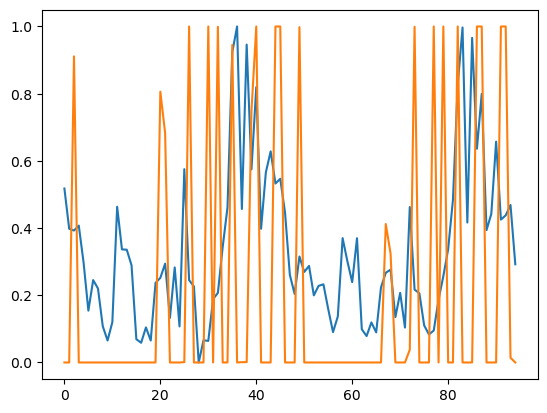

In [39]:
fMRI_variations = np.abs(np.diff(roi_timecourses, axis=1)).sum(axis=1)
plt.plot(standardize_array(fMRI_variations))
plt.plot(solutions.mean(axis=0))

In [41]:
from scipy import stats
stats.pearsonr(standardize_array(fMRI_variations), solutions.mean(axis=0)).statistic

0.24207581575853557

In [ ]:
# plot_stat_on_surf.plot_node_signal_on_surf(even_distribution(mean_distribution, factor=1),
#                                            roi_path, gmregions_names, vmin=-0.2, vmax=1.2, cmap='gnuplot2')